# Project: Identify Customer Segments
Author: Yu Ling Wu, January 2022

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter= ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter= ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('The general demographics data has', azdias.shape[0], 'rows and', azdias.shape[1], 'columns.')
print('The feature summary has', feat_info.shape[0], 'rows and', feat_info.shape[1], 'columns.')

The general demographics data has 891221 rows and 85 columns.
The feature summary has 85 rows and 4 columns.


In [4]:
azdias.iloc[:, 0:20].head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0


In [5]:
azdias.iloc[:, 20:40].head()

,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ
0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN
1,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0
2,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0
3,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0
4,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0


In [6]:
azdias.iloc[:, 40:60].head()

,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015
0,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51
2,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24
3,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12
4,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43


In [7]:
azdias.iloc[:, 60:80].head()

,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0
2,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0
3,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0
4,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0


In [8]:
azdias.iloc[:, 80:85].head()

,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,NaN,NaN,NaN,NaN
1,5.0,4.0,3.0,5.0,4.0
2,4.0,4.0,3.0,5.0,2.0
3,3.0,4.0,2.0,3.0,3.0
4,3.0,3.0,4.0,6.0,5.0


In [9]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:
feat_info.tail()

,attribute,information_level,type,missing_or_unknown
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"
84,RELAT_AB,community,ordinal,"[-1,9]"


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
# Create copies for the cleaning
azdias_clean = azdias.copy()
feat_info_clean = feat_info.copy()

In [12]:
# Identify missing or unknown data values and convert them to NaNs.
# Remove the square brackets and split them to make a list and convert them into floats

In [13]:
# Convert the 'missing_or_unknown' column into lists of the missing or unknown values
missing_alpha = [] # list to store columns with alphanumeric missing values
for row in range(len(feat_info_clean)):
    # the string that lists the missing or unknown values
    miss = feat_info_clean.iloc[row, 3]
    
    if len(miss) > 2: # if this list is not empty
        if re.search('[a-zA-Z]', miss): # if the missing values contain something alphanumeric leave all as string
            missing_alpha.append(feat_info_clean.iloc[row, 0])
            missing = miss[1:-1].split(',')
        else: # if the missing values are all numeric then cast into floats
            missing = [float(i) for i in miss[1:-1].split(',')]
    else: # if this list is empty
        missing = []
    
    # replace the current string in column 'missing_or_unknown' with the list
    feat_info_clean.at[row, 'missing_or_unknown'] = missing

In [14]:
# Attributes that have an alphanumeric code for the missing values 
missing_alpha

['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']

In [15]:
# Check entry where all are numeric and items in list thus a float
feat_info_clean.iloc[0,3]

[-1.0, 0.0]

In [16]:
# Check entry where some are alphanumeric and all items in list thus a string
feat_info_clean.iloc[57, 3]

['-1', 'X']

In [17]:
# Check what it looks like
feat_info_clean.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1.0, 0.0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1.0, 0.0, 9.0]"
2,ANREDE_KZ,person,categorical,"[-1.0, 0.0]"
3,CJT_GESAMTTYP,person,categorical,[0.0]
4,FINANZ_MINIMALIST,person,ordinal,[-1.0]


In [18]:
# Look at some rows that contain both numeric and alphanumeric labels for the missing values
feat_info_clean.iloc[55:60, :]

,attribute,information_level,type,missing_or_unknown
55,OST_WEST_KZ,building,categorical,[-1.0]
56,WOHNLAGE,building,mixed,[-1.0]
57,CAMEO_DEUG_2015,microcell_rr4,categorical,"[-1, X]"
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"


In [19]:
# Replace the missing or unknowns with NaN
# Loop over all attributes
# If in the list of missing_or_unknowns then replace with np.nan
for col in list(feat_info_clean['attribute']):
    azdias_clean.loc[azdias_clean[col].isin(feat_info_clean[feat_info_clean['attribute'] == col].iloc[0, 3]), col] = np.nan

In [20]:
# Check that for CAMEO_DEU_2015 all XX are replaced with NaN, by checking there are no XX's anymore
azdias_clean[azdias_clean['AGER_TYP'] == -1]

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB


In [21]:
# Check that for CAMEO_DEU_2015 all XX are replaced with NaN, by checking there are no XX's anymore
azdias_clean[azdias_clean['CAMEO_DEU_2015'] == 'XX']

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB


In [22]:
# Print for the attributes/columns that had alphanumeric missing values what the unique values are after cleaning
for col in missing_alpha:
    print(col)
    print(azdias_clean[col].unique())

CAMEO_DEUG_2015
[nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
CAMEO_DEU_2015
[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']
CAMEO_INTL_2015
[nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32']


CAMEO_DEUG_2015 and CAMEO_INTL_2015 are all numeric. Need to cast convert these strings into numeric.

In [23]:
# Cast CAMEO_DEUG_2015 and CAMEO_INTL_2015 strings into numeric
for col in ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']:
    azdias_clean[col] = azdias_clean[col].astype(float)

In [24]:
# Check it is converted
azdias_clean[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].dtypes

CAMEO_DEUG_2015    float64
CAMEO_INTL_2015    float64
dtype: object

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [25]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_na_raw = azdias.isna().sum(axis= 0)
azdias_na_after_clean = azdias_clean.isna().sum(axis= 0)

In [26]:
# Show top 5 entries of number of NA's before cleaning
azdias_na_raw.head()

AGER_TYP                   0
ALTERSKATEGORIE_GROB       0
ANREDE_KZ                  0
CJT_GESAMTTYP           4854
FINANZ_MINIMALIST          0
dtype: int64

In [27]:
# Show bottom 5 entries of number of NA's before cleaning
azdias_na_raw.tail()

PLZ8_HHZ       116515
PLZ8_GBZ       116515
ARBEIT          97216
ORTSGR_KLS9     97216
RELAT_AB        97216
dtype: int64

In [28]:
# Show top 5 entries of number of NA's after cleaning
azdias_na_after_clean.head()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
dtype: int64

In [29]:
# Create dataframe with number of NA's before and after cleaning including the attribute name
df_azdias_na = pd.concat([azdias_na_raw, azdias_na_after_clean], axis = 1)
df_azdias_na.columns = ['na_raw', 'na_cleaned']
df_azdias_na['attribute'] = np.array(azdias.columns)
df_azdias_na.reset_index(inplace= True, drop= True)

df_azdias_na['frac_na_raw'] = df_azdias_na['na_raw']/azdias.shape[0]
df_azdias_na['frac_na_cleaned'] = df_azdias_na['na_cleaned']/azdias.shape[0]

# Show top 5 entries, also to check df creation went fine
df_azdias_na.head()

,na_raw,na_cleaned,attribute,frac_na_raw,frac_na_cleaned
0,0,685843,AGER_TYP,0.000000,0.769554
1,0,2881,ALTERSKATEGORIE_GROB,0.000000,0.003233
2,0,0,ANREDE_KZ,0.000000,0.000000
3,4854,4854,CJT_GESAMTTYP,0.005446,0.005446
4,0,0,FINANZ_MINIMALIST,0.000000,0.000000


In [30]:
# Investigate patterns in the amount of missing data in each column.
df_azdias_na.describe()

,na_raw,na_cleaned,frac_na_raw,frac_na_cleaned
count,85.000000,85.000000,85.000000,85.000000
mean,57609.858824,98516.811765,0.064641,0.110541
std,78323.462873,146604.203317,0.087883,0.164498
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,18348.000000,93148.000000,0.020587,0.104517
75%,98979.000000,116515.000000,0.111060,0.130736
max,584612.000000,889061.000000,0.655967,0.997576


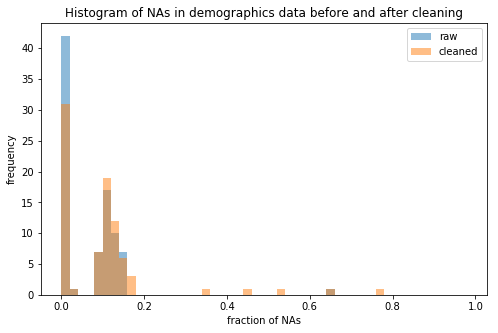

In [31]:
plt.figure(figsize = [8, 5])

bins = np.arange(0, 1, 0.02)

plt.hist(df_azdias_na['frac_na_raw'], bins = bins, alpha = 0.5, label = 'raw')
plt.hist(df_azdias_na['frac_na_cleaned'], bins = bins, alpha = 0.5, label = 'cleaned')
plt.title('Histogram of NAs in demographics data before and after cleaning')
plt.xlabel('fraction of NAs')
plt.ylabel('frequency')
plt.legend();

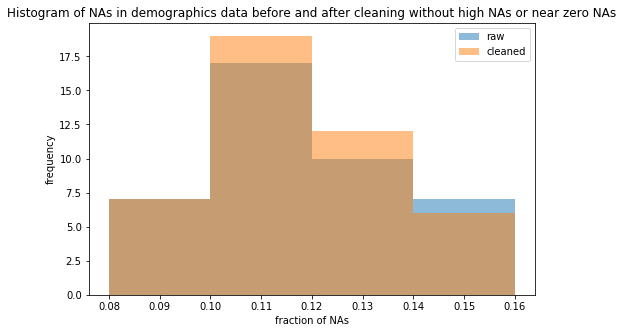

In [32]:
plt.figure(figsize = [8, 5])

bins = np.arange(0.08, 0.18, 0.02)

plt.hist(df_azdias_na[(df_azdias_na['frac_na_raw'] > 0.08) & (df_azdias_na['frac_na_raw'] < 0.2)]['frac_na_raw'], 
         bins = bins, alpha = 0.5, label = 'raw')
plt.hist(df_azdias_na[(df_azdias_na['frac_na_cleaned'] > 0.08) & (df_azdias_na['frac_na_cleaned'] < 0.2)]['frac_na_cleaned'], 
         bins = bins, alpha = 0.5, label = 'cleaned')
plt.title('Histogram of NAs in demographics data before and after cleaning without high NAs or near zero NAs')
plt.xlabel('fraction of NAs')
plt.ylabel('frequency')
plt.legend();

In [33]:
print('Number of attributes without missing values in raw dataset is', 
      df_azdias_na[df_azdias_na['na_raw'] == 0].shape[0])

Number of attributes without missing values in raw dataset is 32


In [34]:
print('Number of attributes without missing values in cleaned dataset is', 
      df_azdias_na[df_azdias_na['na_cleaned'] == 0].shape[0])

Number of attributes without missing values in cleaned dataset is 24


In [35]:
print('Number of attributes with more than 20% missing values in raw dataset is', 
      df_azdias_na[df_azdias_na['frac_na_raw'] >0.2].shape[0])

Number of attributes with more than 20% missing values in raw dataset is 1


In [36]:
print('Number of attributes with more than 20% missing values in cleaned dataset is', 
      df_azdias_na[df_azdias_na['frac_na_cleaned'] >0.2].shape[0])

Number of attributes with more than 20% missing values in cleaned dataset is 6


In [37]:
print('The increase in number of missing values is a factor of',
     df_azdias_na['na_cleaned'].sum()/df_azdias_na['na_raw'].sum())

The increase in number of missing values is a factor of 1.71006861979


In [38]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

In [39]:
# Identify which attributes have more than 20% missing values, which are here classes as the outlier columns
df_azdias_na[df_azdias_na['frac_na_cleaned']>0.2]

,na_raw,na_cleaned,attribute,frac_na_raw,frac_na_cleaned
0,0,685843,AGER_TYP,0.000000,0.769554
11,0,392318,GEBURTSJAHR,0.000000,0.440203
40,73499,889061,TITEL_KZ,0.082470,0.997576
43,73499,310267,ALTER_HH,0.082470,0.348137
47,584612,584612,KK_KUNDENTYP,0.655967,0.655967
64,133324,476524,KBA05_BAUMAX,0.149597,0.534687


In [40]:
# Remove columns with more than 20% missing values
azdias_clean.drop(df_azdias_na[df_azdias_na['frac_na_cleaned']>0.2]['attribute'], axis= 1, inplace= True)

In [41]:
# Check that those columns have been removed
azdias_clean.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [42]:
# Get shape of azdias_clean
azdias_clean.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

- Cleaning led to an increase in the number of missing values. The number of missing values increased by a factor of 1.7
- In the raw dataset, 32 attributes/columns had no missing values, but after cleaning this decreased to 24 attributes.
- The number of attributes consisting fore more than 20% of missing values increased from 1 to 6 by cleaning. These six columns were removed. They are AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP and KBA05_BAUMAX.
- Without the outlier columns containing >20% missing values or columns with <5% missing values, the distribution of missing values followed almost a normal distribution with mode between 10-12% missing values.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [43]:
# How much data is missing in each row of the dataset?
azdias_rowna_raw = azdias.isna().sum(axis= 1)
azdias_rowna_clean = azdias_clean.isna().sum(axis= 1)

In [44]:
# Create dataframe with number of NA's in each row before and after cleaning 
df_azdias_rowna = pd.concat([azdias_rowna_raw, azdias_rowna_clean], axis = 1)
df_azdias_rowna.columns = ['rowna_raw', 'rowna_cleaned']

df_azdias_rowna['frac_rowna_raw'] = df_azdias_rowna['rowna_raw']/azdias.shape[1]
df_azdias_rowna['frac_rowna_clean'] = df_azdias_rowna['rowna_cleaned']/azdias_clean.shape[1]

df_azdias_rowna.head()

,rowna_raw,rowna_cleaned,frac_rowna_raw,frac_rowna_clean
0,42,43,0.494118,0.544304
1,1,0,0.011765,0.000000
2,1,0,0.011765,0.000000
3,2,7,0.023529,0.088608
4,0,0,0.000000,0.000000


In [45]:
df_azdias_rowna.describe()

,rowna_raw,rowna_cleaned,frac_rowna_raw,frac_rowna_clean
count,891221.000000,891221.000000,891221.000000,891221.000000
mean,5.494527,5.649894,0.064641,0.071518
std,12.271097,13.234687,0.144366,0.167528
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.011765,0.000000
75%,1.000000,3.000000,0.011765,0.037975
max,46.000000,49.000000,0.541176,0.620253


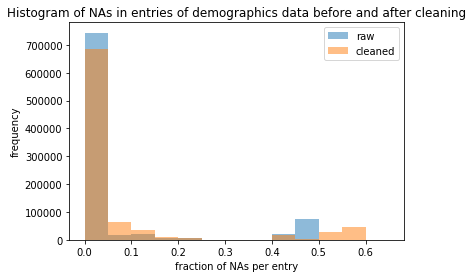

In [46]:
# Plot
bins_row = np.arange(0, 0.7, 0.05)
plt.hist(df_azdias_rowna['frac_rowna_raw'], bins = bins_row, alpha = 0.5, label = 'raw')
plt.hist(df_azdias_rowna['frac_rowna_clean'], bins = bins_row, alpha = 0.5, label = 'cleaned')
plt.title('Histogram of NAs in entries of demographics data before and after cleaning')
plt.xlabel('fraction of NAs per entry')
plt.ylabel('frequency')
plt.legend();

In [47]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_clean_lowNA = azdias_clean[df_azdias_rowna['frac_rowna_clean']< 0.4]
azdias_clean_highNA = azdias_clean[df_azdias_rowna['frac_rowna_clean'] >= 0.4]

In [48]:
# Print number of entries in the two subsets
azdias_clean_lowNA.shape[0], azdias_clean_highNA.shape[0]

(798070, 93151)

In [49]:
# Check all entries are in one of the two subsets
azdias_clean.shape[0] == azdias_clean_lowNA.shape[0] + azdias_clean_highNA.shape[0]

True

In [50]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

In [51]:
print('Number of columns in azdias_clean is', azdias_clean.shape[1])

Number of columns in azdias_clean is 79


In [52]:
# Semi-randomly select five columns for comparison
# Selection by manually entering 5 random numbers lower than total number of columns
colnumb_select = [15, 22, 31, 42, 52]
col_select = list(azdias_clean.columns[colnumb_select])
col_select

['LP_FAMILIE_FEIN',
 'SEMIO_SOZ',
 'SEMIO_KRIT',
 'HH_EINKOMMEN_SCORE',
 'CAMEO_DEUG_2015']

0
LP_FAMILIE_FEIN
Number of not-na emtries (lowNA) 766593
Number of not-na entries (highNA) 46836
1
SEMIO_SOZ
Number of not-na emtries (lowNA) 798070
Number of not-na entries (highNA) 93151
2
SEMIO_KRIT
Number of not-na emtries (lowNA) 798070
Number of not-na entries (highNA) 93151
3
HH_EINKOMMEN_SCORE
Number of not-na emtries (lowNA) 798070
Number of not-na entries (highNA) 74803
4
CAMEO_DEUG_2015
Number of not-na emtries (lowNA) 791868
Number of not-na entries (highNA) 1


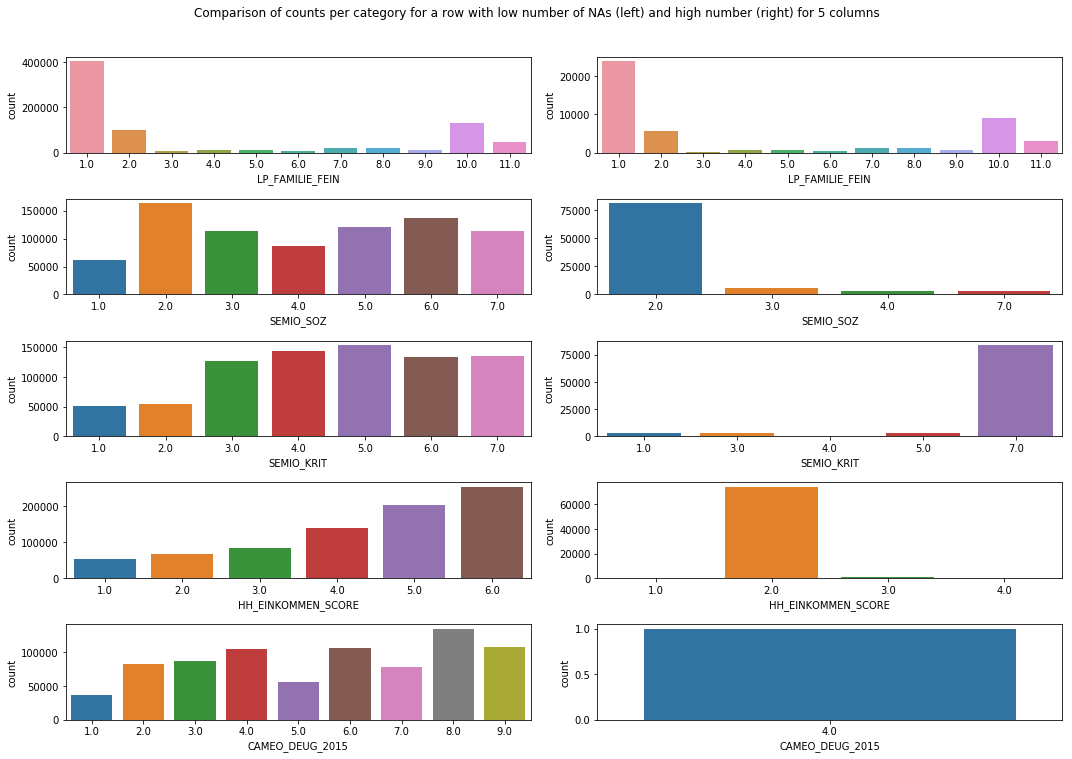

In [53]:
fig, ax = plt.subplots(len(col_select), 2, figsize= (15, 10))
plt.suptitle('Comparison of counts per category for a row with low number of NAs (left) and high number (right) for 5 columns', 
             y= 1.05)
for i in range(len(col_select)):
    print(i)
    print(col_select[i])
    print('Number of not-na emtries (lowNA)', azdias_clean_lowNA[col_select[i]].notna().sum())
    print('Number of not-na entries (highNA)', azdias_clean_highNA[col_select[i]].notna().sum())
    sns.countplot(x= col_select[i], data = azdias_clean_lowNA, ax = ax[i, 0])
    sns.countplot(x= col_select[i], data = azdias_clean_highNA, ax = ax[i, 1])
fig.tight_layout()
    

In [54]:
azdias_clean_highNA.notna().sum(axis= 0)

ALTERSKATEGORIE_GROB     93073
ANREDE_KZ                93151
CJT_GESAMTTYP            93048
FINANZ_MINIMALIST        93151
FINANZ_SPARER            93151
FINANZ_VORSORGER         93151
FINANZ_ANLEGER           93151
FINANZ_UNAUFFAELLIGER    93151
FINANZ_HAUSBAUER         93151
FINANZTYP                93151
GFK_URLAUBERTYP          93048
GREEN_AVANTGARDE         93151
HEALTH_TYP               18684
LP_LEBENSPHASE_FEIN      45761
LP_LEBENSPHASE_GROB      45928
LP_FAMILIE_FEIN          46836
LP_FAMILIE_GROB          46836
LP_STATUS_FEIN           93048
LP_STATUS_GROB           93048
NATIONALITAET_KZ         18762
PRAEGENDE_JUGENDJAHRE    13748
RETOURTYP_BK_S           93048
SEMIO_SOZ                93151
SEMIO_FAM                93151
SEMIO_REL                93151
SEMIO_MAT                93151
SEMIO_VERT               93151
SEMIO_LUST               93151
SEMIO_ERL                93151
SEMIO_KULT               93151
                         ...  
MIN_GEBAEUDEJAHR             3
OST_WEST

In [55]:
# Shape of azdias_clean_lowNA
azdias_clean_lowNA.shape

(798070, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

- The entries/rows with lots of missing values are qualitatively different from entries/rows with few or no missing values: 1) some categories are missing in the case of lots of missing values and 2) the spread between categories is different.
- For the entries/rows with lots of missing values, some columns have no entries other than NA.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [56]:
# How many features are there of each data type?

In [57]:
# Get number of different data types for the features
len(feat_info_clean['type'].unique())

5

In [58]:
# Show what these five data types are
types= feat_info_clean['type'].unique()
types

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'], dtype=object)

In [59]:
# Get number of features for each data type
for t in types:
    print('Number of', t, 'features is', len(feat_info_clean[feat_info_clean['type']== t]))

Number of categorical features is 21
Number of ordinal features is 49
Number of numeric features is 7
Number of mixed features is 7
Number of interval features is 1


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [60]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
attribute_cat = feat_info_clean[feat_info_clean['type']== 'categorical']['attribute']
attribute_cat

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [61]:
drop_list = [] # list to store variables that need to be dropped
keep = 0
reencode = 0
drop = 0
for attr in attribute_cat:
    if attr in azdias_clean.columns:
        if len(azdias_clean_lowNA[attr].unique()) == 2:
            if azdias_clean_lowNA[attr].unique().dtype != 'O': 
                # print(attr, 'is binary numeric: keep as is.')
                keep += 1
            else:
                print('Re-encode', attr)
                reencode += 1
        else:
            # print(attr, 'is multi-level: drop.')
            drop += 1
            drop_list.append(attr)
    else:
        # print(attr, 'is not present in azdias_clean_lowNA: drop')
        drop += 1
        drop_list.append(attr)

print(keep, 'attribute(s) to keep')
print(reencode, 'attribute(s) to re-encode')
print(drop, 'attribute(s) to drop')

Re-encode OST_WEST_KZ
3 attribute(s) to keep
1 attribute(s) to re-encode
17 attribute(s) to drop


In [62]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_clean_lowNA_reenc = azdias_clean_lowNA.join(pd.get_dummies(azdias_clean_lowNA['OST_WEST_KZ'], prefix= 'OST_WEST_KZ'))
azdias_clean_lowNA_reenc.shape

(798070, 81)

In [63]:
azdias_clean_lowNA_reenc.drop(columns= ['OST_WEST_KZ'], inplace = True)
azdias_clean_lowNA_reenc.shape

(798070, 80)

In [64]:
# See which attributes from the drop_list are still in azdias_clean_lowNA_reenc
to_drop = np.intersect1d(drop_list, list(azdias_clean_lowNA_reenc.columns))
to_drop

array(['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP'], 
      dtype='<U21')

In [65]:
# Number of attributes to drop
len(to_drop)

14

In [66]:
# Drop the multi-level categoricals
azdias_clean_lowNA_reenc.drop(columns= to_drop, inplace = True)

In [67]:
azdias_clean_lowNA_reenc.shape

(798070, 66)

The number of columns is now indeed 66 instead of 80, so 14 columns have been dropped. The number of rows is still 798070 as it should be.

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- There were three variables that were binary but numeric and they were kept as is.
- One variable 'OST_WEST_KZ' was binary but with non-numeric values and was thus re-encoded into the variables 'OST_WEST_KZ_O' and 'OST_WEST_KZ_W'. The original variable was removed.
- There were 14 variables that were multi-level categoricals that were still in the cleaned azdias dataframe. They were dropped.

The resulting dataframe is called `azdias_clean_lowNA_reenc`.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [68]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

From `Data_Dictionary.md`:

1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [69]:
# Print all unique values
np.sort(azdias_clean_lowNA_reenc['PRAEGENDE_JUGENDJAHRE'].unique())

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  nan])

In [70]:
# Define function to assign the decade
def label_decade(row):
    if np.isnan(row['PRAEGENDE_JUGENDJAHRE']):
        return np.nan
    elif row['PRAEGENDE_JUGENDJAHRE'] in [1, 2]:
        return '40'
    elif row['PRAEGENDE_JUGENDJAHRE'] in [3, 4]:
        return '50'
    elif row['PRAEGENDE_JUGENDJAHRE'] in [5, 6, 7]:
        return '60'
    elif row['PRAEGENDE_JUGENDJAHRE'] in [8, 9]:
        return '70'
    elif row['PRAEGENDE_JUGENDJAHRE'] in [10, 11, 12, 13]:
        return '80'
    else:
        return '90'

In [71]:
# Create column with the decade
azdias_clean_lowNA_reenc['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_clean_lowNA_reenc.apply(lambda row: label_decade(row), axis= 1)

In [72]:
# Check there is an additional column
azdias_clean_lowNA_reenc.shape

(798070, 67)

In [73]:
# Check the unique values are as expected
azdias_clean_lowNA_reenc['PRAEGENDE_JUGENDJAHRE_DECADE'].unique()

array(['90', '70', '50', '80', '60', nan, '40'], dtype=object)

In [74]:
# Define function to assign movement
def label_movement(row):
    if np.isnan(row['PRAEGENDE_JUGENDJAHRE']):
        return np.nan
    elif row['PRAEGENDE_JUGENDJAHRE'] in [1, 3, 5, 8, 10, 12, 14]:
        return '101'
    else:
        return '102'

In [75]:
# Create column with movement
azdias_clean_lowNA_reenc['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_clean_lowNA_reenc.apply(lambda row: label_movement(row), axis= 1)

In [76]:
# Check there is an additional column
azdias_clean_lowNA_reenc.shape

(798070, 68)

In [77]:
# Check the unique values are as expected
azdias_clean_lowNA_reenc['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].unique()

array(['101', '102', nan], dtype=object)

In [78]:
# Drop the original feature
azdias_clean_lowNA_reenc.drop(columns= ['PRAEGENDE_JUGENDJAHRE'], inplace= True)

In [79]:
azdias_clean_lowNA_reenc.shape

(798070, 67)

Engineering two new features from 'PRAEGENDE_JUGENDJAHRE' went as planned.

From `Data_Dictionary.md`:

4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [80]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

In [81]:
# Print all unique values
np.sort(azdias_clean_lowNA_reenc['CAMEO_INTL_2015'].unique())

array([ 12.,  13.,  14.,  15.,  22.,  23.,  24.,  25.,  31.,  32.,  33.,
        34.,  35.,  41.,  43.,  44.,  45.,  51.,  52.,  54.,  55.,  nan])

In [82]:
# Filter of all entries/row that are not NA
fltr1= np.invert(np.isnan(azdias_clean_lowNA_reenc['CAMEO_INTL_2015']))

In [83]:
azdias_clean_lowNA_reenc.loc[fltr1, 'CAMEO_INTL_2015_WEALTH']= (azdias_clean_lowNA_reenc['CAMEO_INTL_2015']//10)
azdias_clean_lowNA_reenc.loc[fltr1, 'CAMEO_INTL_2015_STAGE']= (azdias_clean_lowNA_reenc['CAMEO_INTL_2015']%10)

In [84]:
# Check conversion went ok:
# Unique values of the two columns
np.sort(azdias_clean_lowNA_reenc['CAMEO_INTL_2015_WEALTH'].unique())

array([  1.,   2.,   3.,   4.,   5.,  nan])

In [85]:
np.sort(azdias_clean_lowNA_reenc['CAMEO_INTL_2015_STAGE'].unique())

array([  1.,   2.,   3.,   4.,   5.,  nan])

In [86]:
# Drop the original feature
azdias_clean_lowNA_reenc.drop(columns= ['CAMEO_INTL_2015'], inplace= True)

In [87]:
azdias_clean_lowNA_reenc.shape

(798070, 68)

The engineering new features from CAMEO_INTL_2015 went as planned.

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- For 'PRAEGENDE_JUGENDJAHRE' there were 6 decades and NA's and there were two movements and NA's. I made two new features, one called 'PRAEGENDE_JUGENDJAHRE_DECADE' and one 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'. I dropped the original feature 'PRAEGENDE_JUGENDJAHRE'.
- For 'CAMEO_INTL_2015' there were 5 different classes of wealth and 5 life stages plus NAs. I created two new features, one called 'CAMEO_INTL_2015_WEALTH' and one called 'CAMEO_INTL_2015_STAGE'. I dropped the original feature.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [88]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [89]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

Dataframe `azdias_clean_lowNA_reenc` is ready to be used for the analysis since it included all from above list of three bullet points, but has excluded the orginal columns.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [90]:
# Define function to assign the decade
def label_decade(row):
    if np.isnan(row['PRAEGENDE_JUGENDJAHRE']):
        return np.nan
    elif row['PRAEGENDE_JUGENDJAHRE'] in [1, 2]:
        return '40'
    elif row['PRAEGENDE_JUGENDJAHRE'] in [3, 4]:
        return '50'
    elif row['PRAEGENDE_JUGENDJAHRE'] in [5, 6, 7]:
        return '60'
    elif row['PRAEGENDE_JUGENDJAHRE'] in [8, 9]:
        return '70'
    elif row['PRAEGENDE_JUGENDJAHRE'] in [10, 11, 12, 13]:
        return '80'
    else:
        return '90'

In [91]:
# Define function to assign movement
def label_movement(row):
    if np.isnan(row['PRAEGENDE_JUGENDJAHRE']):
        return np.nan
    elif row['PRAEGENDE_JUGENDJAHRE'] in [1, 3, 5, 8, 10, 12, 14]:
        return '101' # for Mainstream
    else:
        return '102' # for Avantgarde

In [92]:
def clean_data(df, feat_info, col_clean= 'calculated'):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT:  Demographics DataFrame
            Summary of feature attributes DataFrame
            col_clean is 'calculated' or 'fixed' whether the columns to be removed is calculated based on missing values
                per column or a fixed, hardcoded list
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # Create copies for the cleaning
    df_clean = df.copy()
    feat_info_clean = feat_info.copy()
    print('Made copy of df')
    print('Shape of original dataframe', df.shape)

    # Convert the 'missing_or_unknown' column into lists of the missing or unknown values
    missing_alpha = [] # list to store columns with alphanumeric missing values
    for row in range(len(feat_info_clean)):
        # the string that lists the missing or unknown values
        miss = feat_info_clean.iloc[row, 3]

        if len(miss) > 2: # if this list is not empty
            # if the missing values contain something alphanumeric leave all as string
            if re.search('[a-zA-Z]', miss): 
                missing_alpha.append(feat_info_clean.iloc[row, 0])
                missing = miss[1:-1].split(',')
            else: # if the missing values are all numeric then cast into floats
                missing = [float(i) for i in miss[1:-1].split(',')]
        else: # if this list is empty
            missing = []

        # replace the current string in column 'missing_or_unknown' with the list
        feat_info_clean.at[row, 'missing_or_unknown'] = missing

    # Replace the missing or unknowns with NaN
    # Loop over all attributes
    # If in the list of missing_or_unknowns then replace with np.nan
    for col in list(feat_info_clean['attribute']):
        df_clean.loc[df_clean[col].isin(feat_info_clean[feat_info_clean['attribute'] == col].iloc[0, 3]), col] = np.nan
    
    print('Replaced missing or unknowns with NaN')

    # Cast CAMEO_DEUG_2015 and CAMEO_INTL_2015 strings into numeric
    for col in ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']:
        df_clean[col] = df_clean[col].astype(float)

    # remove selected columns and rows, ... 
    if col_clean == 'calculated':
        # Create dataframe with number of NA's before and after cleaning including the attribute name
        na_raw = df.isna().sum(axis= 0)
        na_after_clean = df_clean.isna().sum(axis= 0)
        df_na = pd.concat([na_raw, na_after_clean], axis = 1)
        df_na.columns = ['na_raw', 'na_cleaned']
        df_na['attribute'] = np.array(df.columns)
        df_na.reset_index(inplace= True, drop= True)

        df_na['frac_na_raw'] = df_na['na_raw']/df.shape[0]
        df_na['frac_na_cleaned'] = df_na['na_cleaned']/df.shape[0]

        # Remove columns with more than 20% missing values
        df_clean.drop(df_na[df_na['frac_na_cleaned']>0.2]['attribute'], axis= 1, inplace= True)
    elif col_clean == 'fixed':
        col_remove = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
        df_clean.drop(columns= col_remove, inplace= True)
    else:
        raise ValueError('Invalid col_clean')
    
    print('Dropped columns with >20% missing values')
    print('Shape after dropping columns', df_clean.shape)
    
    # Create dataframe with number of NA's in each row before and after cleaning 
    rowna_raw = df.isna().sum(axis= 1)
    rowna_clean = df_clean.isna().sum(axis= 1)
    df_rowna = pd.concat([rowna_raw, rowna_clean], axis = 1)
    df_rowna.columns = ['rowna_raw', 'rowna_cleaned']

    # Calculate the fraction of missing values per row
    df_rowna['frac_rowna_raw'] = df_rowna['rowna_raw']/df.shape[1]
    df_rowna['frac_rowna_clean'] = df_rowna['rowna_cleaned']/df_clean.shape[1]

    # Create dataframe with only the rows with low number of missing values
    df_clean_lowNA = df_clean[df_rowna['frac_rowna_clean']< 0.4]
    
    print('Only kept rows with low number of missing values')
    print('Shape after dropping rows', df_clean_lowNA.shape)
    print('Number of entries/rows with high NA per row thus dropped is', (df_rowna['frac_rowna_clean'] >= 0.4).sum())

    # select, re-encode, and engineer column values.
    # Re-encode categorical variable(s) to be kept in the analysis.
    if 'OST_WEST_KZ' in list(df_clean_lowNA.columns):
        df_clean_lowNA_reenc = df_clean_lowNA.join(pd.get_dummies(df_clean_lowNA['OST_WEST_KZ'], prefix= 'OST_WEST_KZ'))
    else:
        df_clean_lowNA_reenc = df_clean_lowNA.copy()
        print('OST_WEST_KZ was removed when dropping columns with high % missing values')

    # Create list to store variables that need to be dropped because they are categorical and multi-level
    attribute_cat = feat_info_clean[feat_info_clean['type']== 'categorical']['attribute']
    drop_list = [] 
    for attr in attribute_cat:
        if (attr in df_clean_lowNA_reenc.columns) and (len(df_clean_lowNA_reenc[attr].unique()) != 2):
            drop_list.append(attr)

    if 'PRAEGENDE_JUGENDJAHRE' in list(df_clean_lowNA_reenc.columns):
        # Create column with the decade
        df_clean_lowNA_reenc['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_clean_lowNA_reenc.apply(
            lambda row: label_decade(row), axis= 1)

        # Create column with movement
        df_clean_lowNA_reenc['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_clean_lowNA_reenc.apply(
            lambda row: label_movement(row), axis= 1)
    else:
        
        print('PRAEGENDE_JUGENDJAHRE was removed when dropping columns with high % missing values')
    
    if 'CAMEO_INTL_2015' in list(df_clean_lowNA_reenc.columns):
        # Filter of all entries/row that are not NA
        fltr1= np.invert(np.isnan(df_clean_lowNA_reenc['CAMEO_INTL_2015']))

        df_clean_lowNA_reenc.loc[fltr1, 'CAMEO_INTL_2015_WEALTH']= (df_clean_lowNA_reenc['CAMEO_INTL_2015']//10)
        df_clean_lowNA_reenc.loc[fltr1, 'CAMEO_INTL_2015_STAGE']= (df_clean_lowNA_reenc['CAMEO_INTL_2015']%10)
    else:
        print('CAMEO_INTL_2015 was removed when dropping columns with high % missing values')
        
    print('Performed re-encoding')
    
    # Drop original columns that are not needed any more
    if 'OST_WEST_KZ' in list(df_clean_lowNA.columns):
        to_drop = np.append(['OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], drop_list)
    elif 'PRAEGENDE_JUGENDJAHRE' in list(df_clean_lowNA.columns):
        to_drop = np.append(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], drop_list)
    elif 'CAMEO_INTL_2015' in list(df_clean_lowNA.columns):
        to_drop = np.append(['CAMEO_INTL_2015'], drop_list)
    else:
        to_drop = drop_list       
    df_clean_lowNA_reenc.drop(columns= to_drop, inplace= True)
    
    print('Dropped originals that are not needed any more')
    
    # Return the cleaned dataframe.
    return df_clean_lowNA_reenc

In [93]:
azdias_clean= clean_data(azdias, feat_info)

Made copy of df
Shape of original dataframe (891221, 85)
Replaced missing or unknowns with NaN
Dropped columns with >20% missing values
Shape after dropping columns (891221, 79)
Only kept rows with low number of missing values
Shape after dropping rows (798070, 79)
Number of entries/rows with high NA per row thus dropped is 93151
Performed re-encoding
Dropped originals that are not needed any more


In [94]:
azdias_clean.shape

(798070, 68)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [95]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

In [96]:
# Calculate total number of entries in the dataframe
total = azdias_clean.shape[0] * azdias_clean.shape[1]
total

54268760

In [97]:
# Calculate total number of NAs in whole dataframe
total_na = azdias_clean.isna().sum().sum()
total_na

847677

In [98]:
print('Percentage missing values is', round(total_na/total*100, 1), '%.')

Percentage missing values is 1.6 %.


In [99]:
print('Number of rows with NaN is', azdias_clean.shape[0] - azdias_clean.dropna().shape[0])

Number of rows with NaN is 174861


In [100]:
print('Percentage of rows in the cleaned dataframe that contain NaN is', 
      round((azdias_clean.shape[0] - azdias_clean.dropna().shape[0])/azdias_clean.shape[0], 2)*100, '%.')

Percentage of rows in the cleaned dataframe that contain NaN is 22.0 %.


In [101]:
print('Percentage of rows dropped during cleaning is', 
      round((azdias.shape[0] - azdias_clean.shape[0])/azdias.shape[0], 2)*100, '%.')

Percentage of rows dropped during cleaning is 10.0 %.


In [102]:
print('Percentage of rows without NaN compared to original number of rows is', 
      round(azdias_clean.dropna().shape[0]/azdias.shape[0], 2)*100, '%.')

Percentage of rows without NaN compared to original number of rows is 70.0 %.


In [103]:
# Impute the missing values with the most_frequent value in that column
azdias_clean2 = Imputer(strategy= 'most_frequent').fit_transform(azdias_clean)

In [104]:
# Apply feature scaling to the general population demographics data.
# And convert into pd.DataFrame
scaler= StandardScaler().fit(azdias_clean2)
azdias_scaled = pd.DataFrame(scaler.transform(azdias_clean2), columns= list(pd.DataFrame(azdias_clean).columns))

In [105]:
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_STAGE
0,-1.766651,0.957909,-1.494590,1.537915,-1.040683,1.465956,0.958624,1.339321,-0.530406,1.010153,...,0.574312,-0.171399,-0.127039,0.684884,-0.517426,0.517426,1.098060,-0.530406,1.175655,-1.248888
1,0.200522,0.957909,-1.494590,0.864556,-1.766970,-0.571003,0.244102,1.339321,1.885350,1.010153,...,0.574312,-0.171399,-0.127039,-0.789027,-0.517426,0.517426,1.098060,1.885350,-0.869680,0.767096
2,1.184109,0.957909,0.683149,-0.482163,1.138176,-0.571003,-1.184941,-0.791198,-0.530406,-0.311827,...,0.574312,-1.173148,-0.997548,-0.052072,-0.517426,0.517426,-0.267788,-0.530406,-1.551458,-0.576893
3,0.200522,-1.043941,0.683149,0.191196,0.411889,-1.249989,0.244102,-0.791198,-0.530406,1.010153,...,-0.337193,0.830349,0.308215,1.421840,-0.517426,0.517426,-0.267788,-0.530406,0.493877,0.095102
4,-1.766651,0.957909,-0.042764,-1.155523,1.138176,-0.571003,-0.470419,1.339321,-0.530406,1.010153,...,1.485816,-1.173148,-0.997548,-0.052072,-0.517426,0.517426,-1.633635,-0.530406,1.175655,0.767096


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

- Dropping all rows with NaN would mean only having 78% the data after cleaning and cleaning already decreased the number of entries by 10%. Therefore, simply dropping those entries is undesirable. 
- In this case it is better to impute. Imputing with the mode of that column seems most logical here. Another option would be to use the mean for numerical features/columns/attributes and the mode for categorical ones. For simplicity the mode is used for all types. In the sklearn-preprocessing class Imputer this can be achieved by setting the parameter 'strategy' to "most_frequent".
- Scaling was performed with sklearn-preprocessing class StandardScaler with all default parameters.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [106]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

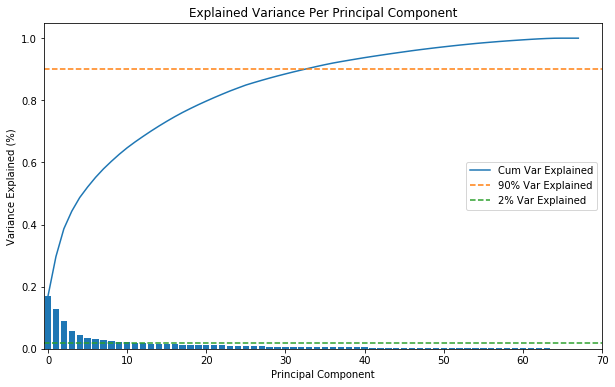

In [107]:
# Investigate the variance accounted for by each principal component.
num_components = len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)

plt.figure(figsize = (10, 6))
plt.bar(ind, vals)
plt.plot(ind, cumvals, label= 'Cum Var Explained')
plt.plot([-0.5, 70], [0.9, 0.9], linestyle= '--', label= '90% Var Explained')
plt.plot([-0.5, 70], [0.02, 0.02], linestyle= '--', label= '2% Var Explained')
plt.legend()
plt.xlim(-0.5, 70)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Explained Variance Per Principal Component');

In [108]:
# Calculate component at which the cumulative explained variance reaches 90%
cutoff = 0.9 # chosen cumulative explained variance that I want to retain
n_comp90 = ind[cumvals > cutoff][0]
print('Number of components required to explain', cutoff*100, '% of the variance is', n_comp90)

Number of components required to explain 90.0 % of the variance is 33


In [109]:
# Calculate component beyond which the explained variance is less than 2%
n_comp02 = ind[vals < 0.02][0]
print('Number of components beyond which the explained variance is less than 2% is', n_comp02)

Number of components beyond which the explained variance is less than 2% is 11


In [110]:
print('Cumulative variance explained with', n_comp02, 'components is', round(cumvals[n_comp02], 2)*100, '%.')

Cumulative variance explained with 11 components is 67.0 %.


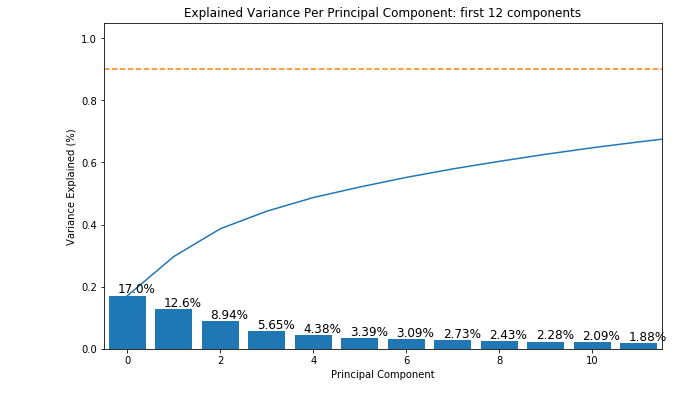

In [111]:
num_components = len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)

plt.figure(figsize = (10, 6))
plt.bar(ind, vals)
plt.plot(ind, cumvals)
for i in range(num_components):
    plt.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
plt.plot([-0.5, 11.5], [cutoff, cutoff], linestyle= '--')
plt.xlim(-0.5, 11.5)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Explained Variance Per Principal Component: first 12 components');

In [112]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca11 = PCA(n_components = n_comp02)
pca11_az = pca11.fit(azdias_scaled)
azdias_pca11 = pca11_az.transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

- Initially I wanted to retain so many components that 90% of the variance would be explained. But that meant keeping as many as 33 components, which is approximately halving the number of components. I wanted a larger reduction of the number of components.
- The scree plot also shows that there are a lot of components that add a little to the explained variance. 
- I changed my criteria to keep the most important ones, which I defined as ones that explain at least 2% of the variance. This meant keeping the first 11 components. These 11 components explained 67% of the variance. Which also means that adding an additional 22 components only adds 23% to the cumulative explained variance. Adding so many components is in my eyes not worth the gain in cumulative explained variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [113]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

In [114]:
def pca_results(scaled_dataset, pca, component_i):
    '''
    Plots the feature weights for the [i]th component of interest
    Creates a DataFrme with the PCA results
    
    INPUT:
    scaled_dataset: DataFrame with the data before pca
    pca: PCA of scaled_dataset
    component_i: [i]the component of which to plot the feature weights
    
    RETURNS:
    DataFrame with the PCA results 
    '''
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca11.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca11.components_, 4), columns = list(pd.DataFrame(azdias_clean).columns))
    components.index = dimensions
    
    # PCA explained variance
    variance_ratios = pd.DataFrame(np.round(pca11.explained_variance_ratio_.reshape(len(pca11.components_), 1), 4), 
                               columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    fig, ax = plt.subplots(figsize= (16, 8))
    dim = components.iloc[component_i -1:component_i, :].index[0]
    components.iloc[component_i -1:component_i, :].sort_values(by= dim, axis= 1).plot(ax= ax, kind= 'bar')
    ax.legend(loc= 'upper center', ncol= 6, bbox_to_anchor= (0.5, 1.5))
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Feature Weights')
    ax.set_xticklabels('%.f'%component_i, rotation= 0)

    for i, ev in enumerate(pca11.explained_variance_ratio_[component_i - 1:component_i]):
        ax.text(i-0.1, ax.get_ylim()[1]-0.05, 'Explained Variance \n %.4f'%(ev))
    
    return pd.concat([variance_ratios, components.sort_values(by= dim, axis= 1)], axis= 1).loc[dim, :]

Explained Variance                0.1703
PLZ8_ANTG1                       -0.2247
MOBI_REGIO                       -0.2189
KBA05_GBZ                        -0.2112
KBA05_ANTG1                      -0.2085
FINANZ_MINIMALIST                -0.2034
PLZ8_GBZ                         -0.1671
KONSUMNAEHE                      -0.1663
INNENSTADT                       -0.1636
LP_LEBENSPHASE_FEIN              -0.1467
LP_LEBENSPHASE_GROB              -0.1328
BALLRAUM                         -0.1259
CAMEO_INTL_2015_STAGE            -0.1173
GEBAEUDETYP_RASTER               -0.1171
PRAEGENDE_JUGENDJAHRE_MOVEMENT   -0.1046
GREEN_AVANTGARDE                 -0.1046
ANZ_PERSONEN                     -0.0957
ALTERSKATEGORIE_GROB             -0.0921
FINANZ_VORSORGER                 -0.0919
WOHNLAGE                         -0.0843
KBA13_ANZAHL_PKW                 -0.0755
ONLINE_AFFINITAET                -0.0615
OST_WEST_KZ_W                    -0.0595
SEMIO_ERL                        -0.0559
WOHNDAUER_2008  

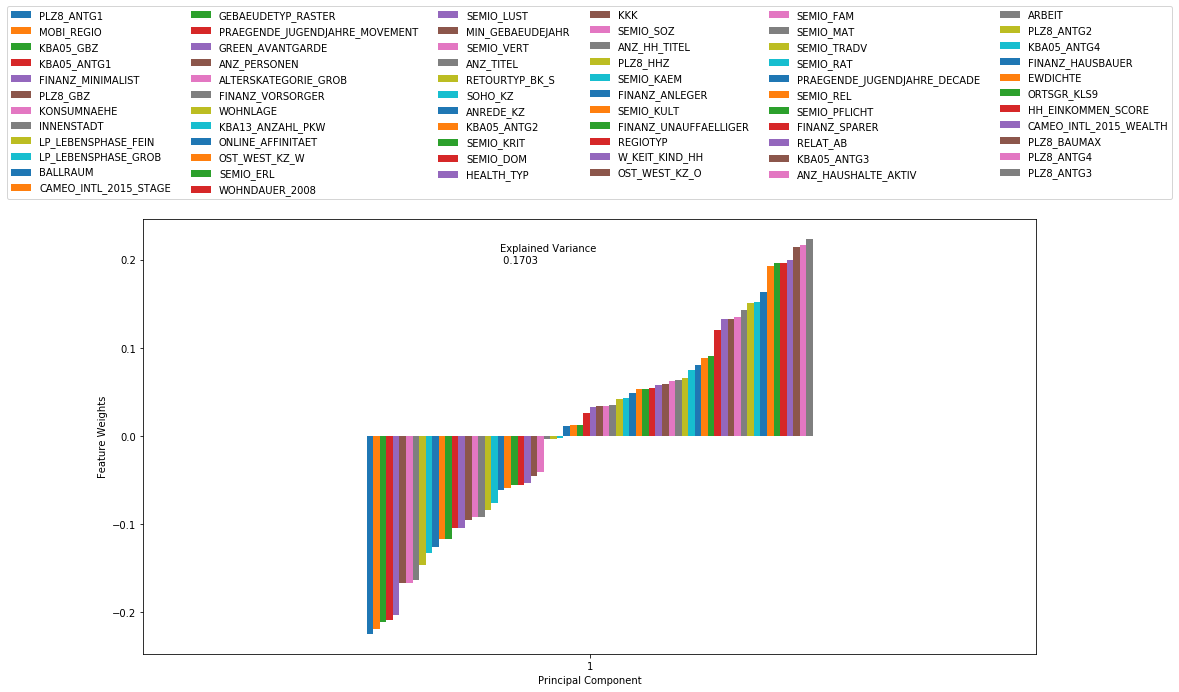

In [115]:
result_component1= pca_results(azdias_scaled, pca11_az, 1)
result_component1

Explained Variance              0.1266
SEMIO_REL                      -0.2653
PRAEGENDE_JUGENDJAHRE_DECADE   -0.2515
FINANZ_SPARER                  -0.2502
SEMIO_PFLICHT                  -0.2395
SEMIO_TRADV                    -0.2379
FINANZ_UNAUFFAELLIGER          -0.2343
SEMIO_KULT                     -0.2245
FINANZ_ANLEGER                 -0.2123
SEMIO_FAM                      -0.1901
SEMIO_RAT                      -0.1798
SEMIO_MAT                      -0.1690
ONLINE_AFFINITAET              -0.1592
SEMIO_SOZ                      -0.1049
PLZ8_ANTG1                     -0.0663
HEALTH_TYP                     -0.0630
SEMIO_VERT                     -0.0626
KBA05_GBZ                      -0.0615
INNENSTADT                     -0.0578
ANZ_PERSONEN                   -0.0574
PLZ8_GBZ                       -0.0535
KONSUMNAEHE                    -0.0523
MOBI_REGIO                     -0.0492
BALLRAUM                       -0.0475
WOHNLAGE                       -0.0461
KBA05_ANTG1              

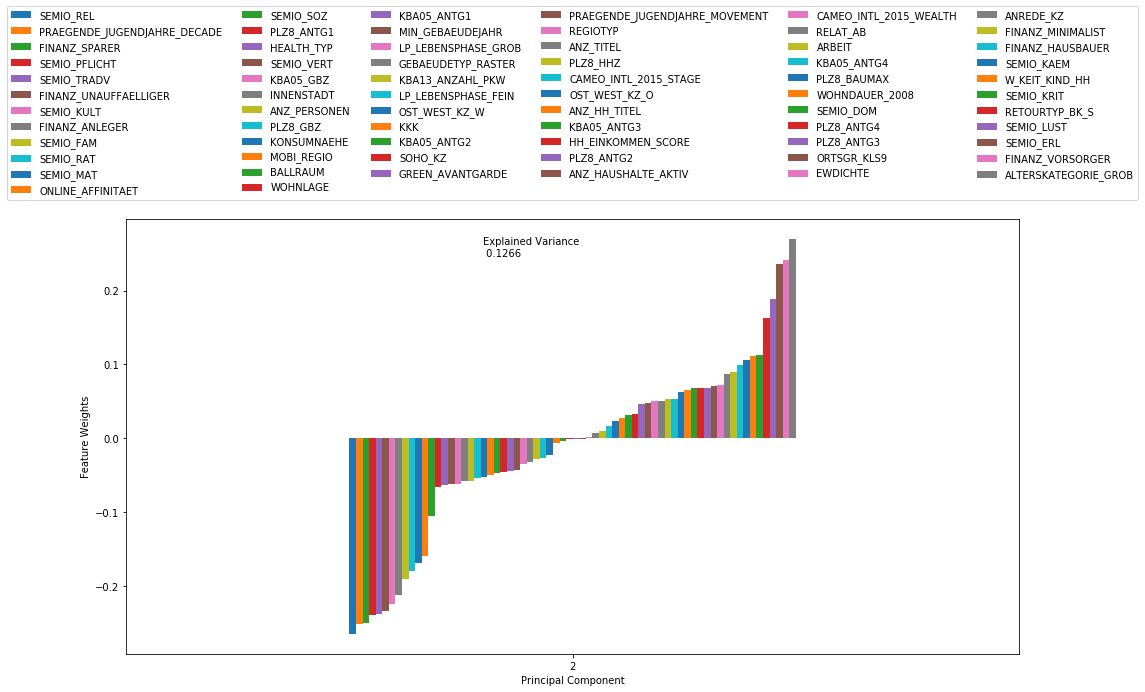

In [116]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
result_component2= pca_results(azdias_scaled, pca11_az, 2)
result_component2

Explained Variance                0.0894
ANREDE_KZ                        -0.3680
SEMIO_KAEM                       -0.3367
SEMIO_DOM                        -0.3129
SEMIO_KRIT                       -0.2772
SEMIO_RAT                        -0.2162
FINANZ_ANLEGER                   -0.1891
SEMIO_ERL                        -0.1772
PRAEGENDE_JUGENDJAHRE_DECADE     -0.1096
FINANZ_SPARER                    -0.1069
FINANZ_UNAUFFAELLIGER            -0.0992
SEMIO_PFLICHT                    -0.0791
SEMIO_TRADV                      -0.0767
ONLINE_AFFINITAET                -0.0485
FINANZ_HAUSBAUER                 -0.0471
PLZ8_ANTG1                       -0.0438
INNENSTADT                       -0.0421
PLZ8_GBZ                         -0.0374
KONSUMNAEHE                      -0.0357
BALLRAUM                         -0.0343
HEALTH_TYP                       -0.0343
GEBAEUDETYP_RASTER               -0.0292
HH_EINKOMMEN_SCORE               -0.0259
KBA13_ANZAHL_PKW                 -0.0233
WOHNLAGE        

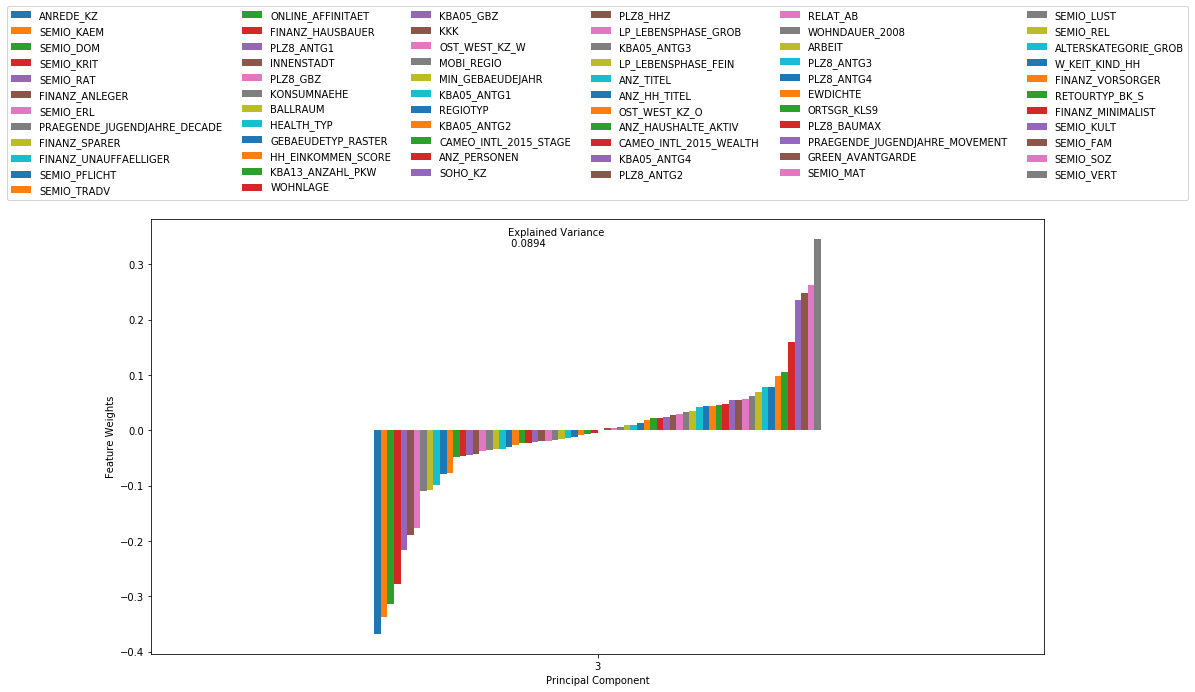

In [117]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
result_component3= pca_results(azdias_scaled, pca11_az, 3)
result_component3

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

- The first principal component explains 17% of the variance. Four of the PLZ8 features, MOBI_REGIO, two of the KBA05 features and FINANZ_MINIMALIST have the highest weights into the first principal component. PLZ8_ANTG1, MOBI_REGIO, KBA05_GB and KBA05_ANTG1 are in opposite direction to PLZ8_BAUMAX, PLZ8_ANTG4 and PLZ8_ANTG3. It is logical that PLZ8_ANTG1 has opposite direction to PLZ8_ANTG3 and PLZ8_ANTG4, because they are all three about the number of people in a family where ANTG1 are 1-2 family homes and ANTG3 and ANTG4 are 6-10 and 10+ family homes and it makes sense that if there are a lot of small family homes that there are less large family homes.
- The second principal component explains 13% of the variance. SEMIO_REL, PRAEGENDE_JUGENDJAHRE_DECADE, FINANZ_SPARER, SEMIO_PFLICHT, SEMIO_TRADV, FINANZ_UNAUFFAELLIGER, SEMIO_KULT, FINANZ_ANLEGER and SEMIO_ERL, FINANZ_VORSORGER, ALTERSKATEGORIE_GROB all have absolute weights larger than 0.2, where the former 8 have opposite direction to the latter 3. It makes sense that the features that have a large weight for the second principal component are different from the features that have large weights for the first principal component.
- The third principal component explains 9% of the variance. Especially SEMIO features have large weights for this principal component. ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_RAT and SEMIO_KULT, SEMIO_FAM, SEMIO_SOZ, SEMIO_VERT have weights larger than 0.2, where the former 5 have opposite direction to the latter 4. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [118]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.    

In [119]:
nclust_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]

In [120]:
score_kmeans= []
n_cluster= []
for n_clust in nclust_list:
    print(n_clust)
    kmeans = KMeans(n_clusters = n_clust, random_state = 21)
    model = kmeans.fit(azdias_pca11)
    score_kmeans.append(np.abs(model.score(azdias_pca11)))
    n_cluster.append(n_clust)

2
3
4
5
6
7
8
9
10
15
20


In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship

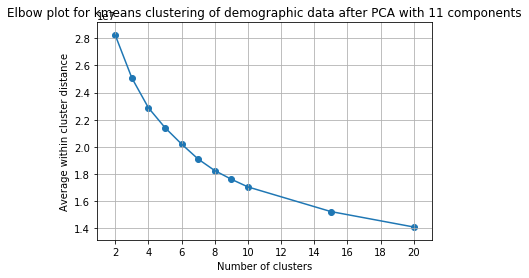

In [121]:
plt.plot(n_cluster, score_kmeans)
plt.scatter(n_cluster, score_kmeans)
plt.xticks(np.arange(2, 21, 2))
plt.grid(visible= True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within cluster distance')
plt.title('Elbow plot for kmeans clustering of demographic data after PCA with 11 components');

In [122]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans5= KMeans(n_clusters = 5, random_state = 21)
kmeans5.fit(azdias_pca11)
azdias_pred_kmeans5 = kmeans5.predict(azdias_pca11)
azdias_score_kmeans5 = np.abs(kmeans5.score(azdias_pca11))

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)
- I ran kmeans with several number of clusters and made an elbow plot. The way to use this is to determine where the 'kink' or elbow is, so beyond where an increase in number of clusters has a much lower effect on the reduction in average within cluster distance. By eye I estimated the elbow to be at 5 clusters. Therefore, I re-fitted the k-means model with 5 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [123]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter= ';')

In [124]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [125]:
azdias_clean.shape

(798070, 68)

In [126]:
# Clean the customer data
customers_clean = clean_data(customers, feat_info)

Made copy of df
Shape of original dataframe (191652, 85)
Replaced missing or unknowns with NaN
Dropped columns with >20% missing values
Shape after dropping columns (191652, 32)
Only kept rows with low number of missing values
Shape after dropping rows (191652, 32)
Number of entries/rows with high NA per row thus dropped is 0
OST_WEST_KZ was removed when dropping columns with high % missing values
PRAEGENDE_JUGENDJAHRE was removed when dropping columns with high % missing values
CAMEO_INTL_2015 was removed when dropping columns with high % missing values
Performed re-encoding
Dropped originals that are not needed any more


In [127]:
customers_clean.shape

(191652, 26)

After cleaning the customer data, only 26 columns are retained, whereas for the general population data 68 columns are left. I can imagine this could have an effect on rest of the analysis. Therefore, I decided not create an adapted cleaning function in which the columns are dropped that are dropped in the general data rather than dropping all columns with >20% missing values. This is built in with a parameter such that the cleaning function is flexible.

In [128]:
# Clean customer data such that the same columns are removed as for the general demographics data
customers_clean = clean_data(customers, feat_info, col_clean= 'fixed')

Made copy of df
Shape of original dataframe (191652, 85)
Replaced missing or unknowns with NaN
Dropped columns with >20% missing values
Shape after dropping columns (191652, 79)
Only kept rows with low number of missing values
Shape after dropping rows (141725, 79)
Number of entries/rows with high NA per row thus dropped is 49927
Performed re-encoding
Dropped originals that are not needed any more


In [129]:
customers_clean.shape

(141725, 68)

In [130]:
# Impute remaining NAs
customers_clean2 = Imputer(strategy= 'most_frequent').fit_transform(customers_clean)

In [131]:
# Perform feature scaling
scaler_cust= StandardScaler().fit(customers_clean2)
customers_scaled = pd.DataFrame(scaler_cust.transform(customers_clean2), columns= list(pd.DataFrame(customers_clean).columns))

In [132]:
# Apply PCA while retaining 11 components
customers_pca11 = pca11_az.transform(customers_scaled)

In [133]:
# Cluster with the model based on the general population
customers_pred_kmeans5 = kmeans5.predict(customers_pca11) 

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [134]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [135]:
# Create list with counts per cluster for general population
azdias_counts = []
for i in range(5):
    azdias_counts.append((azdias_pred_kmeans5== i).sum())
# There were 4993151 entries/rows with more than 20% NA
azdias_counts.append(93151)

In [136]:
azdias_counts

[174992, 152284, 162327, 156661, 151806, 93151]

In [137]:
# Create list with percentages per cluster for general population
azdias_perc = azdias_counts/sum(azdias_counts)

In [138]:
# Create list with counts per cluster for customers
customers_counts = []
for i in range(5):
    customers_counts.append((customers_pred_kmeans5== i).sum())
# There were 49927 entries/rows with more than 20% NA
customers_counts.append(49927)

In [139]:
customers_counts

[29197, 24559, 51143, 22444, 14382, 49927]

In [140]:
# Create list with percentages per cluster for customers
customers_perc = customers_counts/sum(customers_counts)

In [141]:
# Create dataframe with proportions in each cluster
df_cluster_perc = pd.DataFrame(list(zip(azdias_perc, customers_perc)), columns = ['general', 'customers'])
df_cluster_perc

,general,customers
0,0.196351,0.152344
1,0.170871,0.128144
2,0.182140,0.266853
3,0.175782,0.117108
4,0.170335,0.075042
5,0.104521,0.260509


Text(0.5,1,'Percentage per cluster')

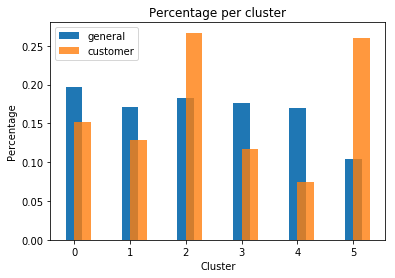

In [142]:
plt.bar(x= df_cluster_perc.index, height= df_cluster_perc['general'], width= 0.3, label= 'general')
plt.bar(x= df_cluster_perc.index, height= df_cluster_perc['customers'], width= 0.3, align= 'edge', label= 'customer', alpha= 0.8)
plt.legend()
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title('Percentage per cluster')

In [143]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

Cluster 4 (and the highNA cluster) is overrepresented in the customer data. I will take cluster 4 to investigate what type of people they are.

In [144]:
# Show the coordinates of the center of cluster 3
(kmeans5.cluster_centers_[4]).round(1)

array([ 4.4, -2. , -0.2,  0.2,  0. , -0.1, -0. ,  0. ,  0.1,  0. ,  0.1])

In [145]:
# Invert the pca
cluster4_pcainv = pca11_az.inverse_transform(kmeans5.cluster_centers_[4]).round(1)
# Also invert scaling
cluster4_scalpcainv = scaler.inverse_transform(pca11_az.inverse_transform(kmeans5.cluster_centers_[4])).round(1)
# Create df
df_cluster4 = pd.DataFrame(
    data= np.concatenate((cluster4_pcainv.reshape(68, 1), cluster4_scalpcainv.reshape(68, 1)), axis= 1)
    , index = azdias_clean.columns, columns= ['PCAinverse', 'ScalerPCA_inverse'])

In [146]:
df_cluster4.head()

,PCAinverse,ScalerPCA_inverse
ALTERSKATEGORIE_GROB,-1.0,1.8
ANREDE_KZ,-0.0,1.5
FINANZ_MINIMALIST,-1.1,1.5
FINANZ_SPARER,1.1,4.3
FINANZ_VORSORGER,-0.9,2.2


In [147]:
df_cluster4.sort_values(by= 'PCAinverse').head(10)

,PCAinverse,ScalerPCA_inverse
FINANZ_MINIMALIST,-1.1,1.5
ALTERSKATEGORIE_GROB,-1.0,1.8
FINANZ_VORSORGER,-0.9,2.2
PLZ8_ANTG1,-0.8,1.4
MOBI_REGIO,-0.8,1.7
KBA05_GBZ,-0.8,2.2
KBA05_ANTG1,-0.8,0.4
SEMIO_ERL,-0.7,3.4
PLZ8_GBZ,-0.6,2.7
INNENSTADT,-0.6,3.3


In [148]:
df_cluster4.sort_values(by= 'PCAinverse').tail(10)

,PCAinverse,ScalerPCA_inverse
PLZ8_ANTG3,0.8,2.4
PLZ8_ANTG4,0.8,1.3
PLZ8_BAUMAX,0.8,3.1
HH_EINKOMMEN_SCORE,0.8,5.6
SEMIO_TRADV,0.8,5.1
ORTSGR_KLS9,0.8,7.0
SEMIO_REL,0.9,5.7
SEMIO_PFLICHT,0.9,5.8
PRAEGENDE_JUGENDJAHRE_DECADE,0.9,87.0
FINANZ_SPARER,1.1,4.3


In [149]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

Customers are most underrepresented in cluster 0. 

In [150]:
(kmeans5.cluster_centers_[0]).round(1)

array([ 2.6,  3.1,  0.6, -0.2,  0.2,  0.3, -0. , -0. ,  0.1, -0. , -0.1])

In [151]:
# Invert the pca
cluster0_pcainv = pca11_az.inverse_transform(kmeans5.cluster_centers_[0]).round(1)
# Also invert scaling
cluster0_scalpcainv = scaler.inverse_transform(pca11_az.inverse_transform(kmeans5.cluster_centers_[0])).round(1)
# Create df
df_cluster0 = pd.DataFrame(
    data= np.concatenate((cluster0_pcainv.reshape(68, 1), cluster0_scalpcainv.reshape(68, 1)), axis= 1)
    , index = azdias_clean.columns, columns= ['PCAinverse', 'ScalerPCA_inverse'])

In [152]:
df_cluster0.sort_values(by= 'PCAinverse').head(10)

,PCAinverse,ScalerPCA_inverse
MOBI_REGIO,-0.8,1.7
KBA05_ANTG1,-0.8,0.3
PLZ8_ANTG1,-0.8,1.5
KBA05_GBZ,-0.8,2.1
PRAEGENDE_JUGENDJAHRE_DECADE,-0.7,64.3
FINANZ_UNAUFFAELLIGER,-0.7,1.7
ONLINE_AFFINITAET,-0.7,1.7
SEMIO_REL,-0.6,2.9
SEMIO_TRADV,-0.6,2.6
FINANZ_SPARER,-0.6,1.9


In [153]:
df_cluster0.sort_values(by= 'PCAinverse').tail(10)

,PCAinverse,ScalerPCA_inverse
RETOURTYP_BK_S,0.6,4.3
FINANZ_HAUSBAUER,0.7,4.1
HH_EINKOMMEN_SCORE,0.7,5.4
EWDICHTE,0.7,5.1
CAMEO_INTL_2015_WEALTH,0.7,4.4
ORTSGR_KLS9,0.7,6.9
ALTERSKATEGORIE_GROB,0.7,3.5
PLZ8_BAUMAX,0.8,3.0
PLZ8_ANTG4,0.8,1.3
PLZ8_ANTG3,0.8,2.4


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)
- Cluster 4 and the additional cluster with the entries with high missing values is overrepresented in the customer data. I took cluster 4 to investigate what type of people they are.
- The center of cluster 4 plots at large negative first principal component (PC) and large positive third PC. And it is close to zero for the other PC's. 
- Cluster 4, i.e. overrepresented in the customer data, included people that have a highly cultural, family, religious, socially, materialistic, dutiful, traditional or dreamful minded minded. They have a low affinity with event-orientated, cirital-minded, combative attitude or dominant-minded personalities. They consist more of 1-2 family homes and less of 10+ family homes.
- Customers are most underrepresented in cluster 0. 
- The center of cluster 0 plots at large positive first PC and large negative second PC. The other PC's are close to zero.
- Cluster 0, i.e. underrepresented in the customer data, are on average from the 60s to 70s. They consist more of 6-10 family homes and less of 1-2 family homes. Their movement pattern is high.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.